In [147]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.vector_ar.vecm import VECM
from patsy import dmatrices
import itertools
from IPython.display import clear_output
pd.set_option('future.no_silent_downcasting', True)
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

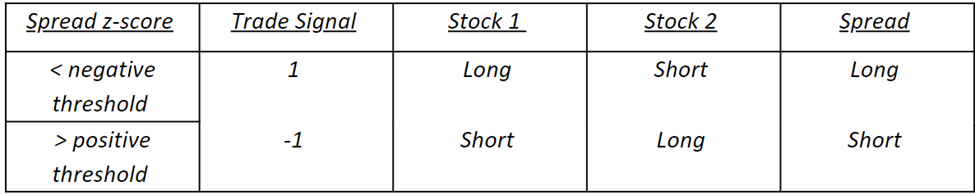


In [140]:
class PairsTrade:
    '''Class for Backtesting a Pairs Trading strategy using the cointegration method of pair creation with speed of adjustment filtering'''

    def __init__(self, start, end, formation_period, trading_period, filter, open_sd_threshold, close_sd_threshold): # Constructor Method
        
        self.start = start
        self.end = end
        self.formation_period = slice(*formation_period)
        self.trading_period = slice(*trading_period)
        self.filter = filter
        self.open_threshold = open_sd_threshold
        self.close_threshold = close_sd_threshold
        self.get_data()
        self.get_close_prices()
        self.clean_data()  
        self.intorder()
        self.normalize_price_series()
        self.cointegration_testing()
        self.speedfiltering()
        self.generate_spreads()
        self.formation_analysed= self.calculate_spread_analysis(self.formation_spread_df)
        self.trading_analysed = self.calculate_spread_analysis(self.trading_spread_df)
        self.generate_signals()
        self.run_pairs_trading_strategy()
        
    def get_data(self):

        self.table = pd.read_html('https://en.wikipedia.org/wiki/Nasdaq-100')[4]
        self.tickers_raw = self.table.iloc[:,1]
        self.tickers_Series = self.tickers_raw 
        self.tickers = self.tickers_Series.tolist()
        self.data = yf.download(self.tickers, start = self.start, end = self.end)
        if self.data.empty:
            print(f'No Data pulled for period {self.start} : {self.end}')

        else:
            swapped_columnindex = self.data.columns.swaplevel(0,1)
            data_copy = self.data.copy()
            data_copy.columns = swapped_columnindex
            data_copy = data_copy.sort_index(axis = 1, level = 0)
            self.data = data_copy
            self.data.columns = self.data.columns.set_levels(self.data.columns.levels[0].str.replace('.L', "", regex = False), level = 0)
            print("Data successfully retrieved")
            print('=' * 55)

    def plot_stock(self,symbol, cols=None):
        self.symbol = symbol
        if cols is None:
            cols = "Close"
        self.data.xs(symbol, level = 0, axis = 1)[cols].plot(figsize = (10,6), title = (f'A Graph of {self.symbol} {cols} Prices'))

    def get_close_prices(self):
        self.df = self.data.xs('Close', level=1, axis=1)

    
    def get_date_price(self,bar,symbol):
        rawdate = pd.to_datetime(bar)
        if rawdate in self.df.index:
            price = self.df.loc[rawdate, symbol]
            return str(rawdate.date()), price
        else:
            print(f"Date {rawdate} not found in data.")

    def clean_data(self):
        initial_column_count = self.df.shape[1]
        self.df_cleaned = self.df.dropna(axis=1, how = 'any')
        dropped_columns_count = initial_column_count - self.df_cleaned.shape[1]
        print(f"Number of columns dropped during cleaning for stationarity testing: {dropped_columns_count}")
        total_nans_cleaned = self.df_cleaned.isna().sum().sum()
        print(f"Total Number of NANs in the entire DataFrame after column removal: {total_nans_cleaned}")
        self.df = self.df_cleaned

    # Order of Integration Testing

    def intorder(self):
        def adf_test(series):
            result = sm.tsa.stattools.adfuller(series, autolag = 'BIC')
            return result[1]
        self.adfp = self.df.apply(adf_test, axis = 0) > 0.05
        diff_series = self.df.loc[:, self.adfp].diff().dropna()
        self.adfp2 = diff_series.apply(adf_test, axis = 0) > 0.05
        adfp2_alligned = self.adfp2.reindex(self.df.columns, fill_value = True)
        self.i1_prices = self.df.loc[:, ~adfp2_alligned]
        print(f" {len(self.i1_prices.columns)} I(1) Stocks")
        print("=" * 55)


    def normalize_price_series(self):
        self.norm_i1prices = self.i1_prices/ self.i1_prices.iloc[0]

    # Cointegration testing

    def cointegration_testing(self):
        self.formation_prices = self.norm_i1prices[self.formation_period]
        self.trading_prices = self.norm_i1prices[self.trading_period]

        self.stock_combinations = list(itertools.combinations(self.norm_i1prices.columns, 2))
        self.cointegrated_pairs = []
        self.cointegration_results = {
            'Stock 1': [],
            'Stock 2': [],
            'Alpha': [],
            'Average Alpha' : [],
            'Beta': [],
            'Constant' : []
        }
        for stock1 , stock2 in self.stock_combinations:

            Pairs_close = self.formation_prices[[stock1, stock2]]
            Pairs_close = Pairs_close.asfreq('B').ffill()

            #lag selection 
            var_model = sm.tsa.VAR(Pairs_close)
            lag_selection = var_model.select_order(maxlags = 15, trend = 'c')
            optimal_lag = lag_selection.bic        
            # Serial autocorrelation test - issue need to return
            #self.residuals = self.var_result.resid
            #out = sm.stats.stattools.durbin_watson(var_model.resid)
            #print(out) 

            coint_johansen_result = coint_johansen(Pairs_close, 0, optimal_lag)
            trace_stat = coint_johansen_result.lr1
            trace_critical_value = coint_johansen_result.cvt
           
            if trace_stat[0] > trace_critical_value[1,2]:
                self.cointegrated_pairs.append((stock1, stock2))

                model = VECM(Pairs_close, deterministic = 'ci', seasons = 0, k_ar_diff= optimal_lag , coint_rank= 1) # rank n.b
                vecm_result= model.fit()
                                       
                self.cointegration_results['Stock 1'].append(stock1)
                self.cointegration_results['Stock 2'].append(stock2)
                self.cointegration_results['Alpha'].append(vecm_result.alpha)
                self.cointegration_results['Average Alpha'] =  [(abs(alpha[0]) + abs(alpha[1])) / 2 for alpha in self.cointegration_results['Alpha']] # magnitude
                self.cointegration_results['Beta'].append(vecm_result.beta)
                self.cointegration_results['Constant'].append(vecm_result.const_coint)

        print(f"For Stock Pair {stock1}, {stock2}:")
        print(f"Trace Statistic: {trace_stat}")
        print(f"Trace Statistic Critical Values (10%, 5%, 1%):\n{trace_critical_value}")
        print(f"Stock Pair {stock1}, {stock2} is cointegrated")
        print("=" * 55)
                
        self.cointegration_df = pd.DataFrame(self.cointegration_results)
        self.cointegrated_pairs = self.cointegration_df.iloc[:, :2]
        
        print(f"Out of {len(self.stock_combinations)}  possible pairs there are {len(self.cointegration_df)} cointegrated pairs")


    def speedfiltering(self):
        self.filtered_pairs = self.cointegration_df[self.cointegration_df['Average Alpha'] > self.filter]
        print(f"Out of {len(self.cointegration_df)} Cointegrated Pairs there are {len(self.filtered_pairs)} Pairs with a Speed of Adjustment Coefficient greater than {self.filter}.")
        

    def generate_spreads(self):

        self.formation_spread_df = pd.DataFrame(index = self.formation_prices.index)
        self.trading_spread_df = pd.DataFrame(index = self.trading_prices.index)
        
        stocks1 = self.filtered_pairs['Stock 1'].values
        stocks2 = self.filtered_pairs['Stock 2'].values
        betas = self.filtered_pairs['Beta'].values
        constants = self.filtered_pairs['Constant'].values

        def calculate_spreads(prices, spread_df):
            for i in range(len(stocks1)):
                beta1, beta2 = betas[i]
                constant_value = constants[i][0][0]
                prices1 = prices.loc[:, stocks1[i]]
                prices2 = prices.loc[:, stocks2[i]]

                spread = constant_value + (prices1 * beta1) + (prices2 * beta2)
                spread_df[f"{stocks1[i]} - {stocks2[i]}"] = spread

        calculate_spreads(self.formation_prices, self.formation_spread_df)
        calculate_spreads(self.trading_prices, self.trading_spread_df)
    

    def calculate_spread_analysis(self, spread_df):
        pairs = spread_df.columns
        mean_spreads= np.mean(spread_df, axis=0)
        std_spreads = np.std(spread_df, axis = 0)
        spread_analysis = pd.DataFrame({
            'Pair' : pairs,
            'Mean_of_spread' : mean_spreads,
            'SD_spread': std_spreads})        
        return spread_analysis


    def generate_signals(self):
        open_threshold = self.open_threshold
        close_threshold = self.close_threshold
        pair_names = self.trading_spread_df.columns
        columns = pd.MultiIndex.from_product([pair_names, ['Spread','Z-score','Signal']], names=['Pair', 'Metric'])
        self.signals_df = pd.DataFrame(index= self.trading_spread_df.index, columns= columns)

        for pair in self.trading_spread_df.columns:
            spread = self.trading_spread_df[pair]
            self.signals_df[(pair,'Spread')] = spread
            mean_spread = self.formation_analysed.loc[pair, 'Mean_of_spread']
            std_spread = self.formation_analysed.loc[pair, 'SD_spread']
            z_score =   (spread - mean_spread)/ std_spread
            self.signals_df[(pair,'Z-score')] = z_score
            self.signals_df.loc[self.signals_df.index[0], (pair, 'Signal')] = 0
    
            for i in range(1, len(self.signals_df)):
                if (self.signals_df[(pair, 'Z-score')].iloc[i] > open_threshold) and (self.signals_df[(pair, 'Signal')].iloc[i-1] == 0):
                    self.signals_df.loc[self.signals_df.index[i], (pair, 'Signal')] = -1  # Short signal
                elif (self.signals_df[(pair, 'Z-score')].iloc[i] < -open_threshold) and (self.signals_df[(pair, 'Signal')].iloc[i-1] == 0):
                    self.signals_df.loc[self.signals_df.index[i], (pair, 'Signal')] = 1   # Long signal
                elif (self.signals_df[(pair, 'Z-score')].iloc[i] > -close_threshold) and (self.signals_df[(pair, 'Signal')].iloc[i-1] == 1):
                    self.signals_df.loc[self.signals_df.index[i], (pair, 'Signal')] = 0   # Close long position
                elif (self.signals_df[(pair, 'Z-score')].iloc[i] < close_threshold) and (self.signals_df[(pair, 'Signal')].iloc[i-1] == -1):
                    self.signals_df.loc[self.signals_df.index[i], (pair, 'Signal')] = 0   # Close short position
                else:
                    self.signals_df.loc[self.signals_df.index[i], (pair, 'Signal')] = self.signals_df[(pair, 'Signal')].iloc[i-1]

            self.signals_df[(pair, 'Signal')] = self.signals_df[(pair, 'Signal')].ffill()
            self.signals_df = self.signals_df.infer_objects(copy=False)

    def place_buy_order(self, bar, stock, units = None, amount = None, verbose = True):
        date, price = self.get_date_price(bar,stock)
        if units is None:
            units = 1
        # total_cost = (units * price)
        # self.amount -= total_cost
        # self.units += units
        # self.trades += 1
        if verbose:
            print(f'{date} | Buying {units} of {stock} at {price:.2f}')
            print('=' * 55)

    
    def place_sell_order(self, bar, stock, units=None, amount = None, verbose = True):
        '''Place a Sell order'''
        date, price = self.get_date_price(bar, stock)
        if units is None:
            units = 1
        # total_revenue = (units*price)  #* (1 - self.ptc) - self.ftc
        # self.amount += total_revenue
        # self.units -= units
        # self.trades += 1
        if verbose:
            print(f'{date} | Selling {units} of {stock} at {price:.2f}')
            print('=' * 55)

    def go_long(self, bar, stock1, stock2, units=None, amount=None):
        '''Execute a long position on stock1 and short position on stock2.'''
        self.units = units
        self.place_buy_order(bar, stock = stock1, units = self.units)
        self.position = 'LONG'
        self.place_sell_order(bar, stock = stock2, units = self.units)

    def go_short(self, bar, stock1, stock2, units = None, amount = None):
        self.units = units
        self.place_sell_order(bar,stock = stock1, units = self.units)
        self.place_buy_order(bar,stock = stock2, units = self.units)
        self.position = 'SHORT'

    def close_long(self, bar, stock1, stock2, units = None, amount = None):
        self.place_sell_order(bar, stock1)
        self.place_buy_order(bar, stock2)

    def close_short(self,bar, stock1, stock2, units = None, amount = None):
        self.place_buy_order(bar, stock1)
        self.place_sell_order(bar, stock2)

    def close_out(self, bar):
        '''Closing out positions at the end of the backtest period'''
        date, price = self.get_date_price(bar)
        # self.amount += self.units * price
        #self.units = self.units
        if self.verbose:
            print(f'{date} | inventory {self.units} units at {price:.2f}')
            print('=' * 55)
            print('Final balance [$] {:.2f}'.format(self.amount))
            perf = ((self.amount - self.initial_amount) /
                    self.initial_amount * 100)
            print('Net Performance [%] {:.2f}'.format(perf))
            print('Trades executed [#] {:.2f}'.format(self.trades))
            print('=' * 55)    

    def initialise_trading_parameters(self):
            self.position = 0

    def run_pairs_trading_strategy(self):
        self.computed_df = self.signals_df.copy()
        signal_change = self.signals_df.xs('Signal', axis = 1 , level = 1).diff()
        for pair in self.signals_df.columns.get_level_values(0).unique():
            stock1, stock2 = pair.split(" - ")
            self.computed_df[(pair, 'Signal Change')] = signal_change[pair]
            self.computed_df[(pair, 'Stock 1 Price')] = self.df[stock1]
            self.computed_df[(pair, 'Stock 2 Price')] = self.df[stock2]
            self.computed_df[(pair, 'Position')] = 'NO_POSITION'
            self.computed_df[(pair, 'Entry Price S1')] = 0.0
            self.computed_df[(pair, 'Exit Price S1')] = 0.0
            self.computed_df[(pair, 'Entry Price S2')] = 0.0
            self.computed_df[(pair, 'Exit Price S2')] = 0.0
            self.computed_df[(pair, 'Trade Return')] = 0.0
            self.computed_df[(pair, 'Cumulative Return')] = 0.0

        pairs = self.computed_df.columns.get_level_values(0).unique()
        metric_sort = ['Stock 1 Price', 'Stock 2 Price', 'Spread', 'Z-score', 'Signal', 'Signal Change', 'Position', 'Entry Price S1', 'Entry Price S2', 'Exit Price S1', 'Exit Price S2',
                        'Trade Return', 'Cumulative Return']
        new_columns = pd.MultiIndex.from_product([pairs, metric_sort])
        self.computed_df = self.computed_df.reindex(columns = new_columns)
        self.computed_df.columns.names = ['Pair', 'Metric']

        for pair in pairs:
            stock1, stock2 = pair.split(" - ")
            self.initialise_trading_parameters()
            z_score = self.computed_df[(pair, 'Z-score')]
            signal_change = self.computed_df[(pair, 'Signal Change')]
            position = self.computed_df[(pair, 'Position')]
            

            for bar in self.computed_df.index:
                yday_position = position.shift(1).loc[bar] 
                yday_entry_stock1 = self.computed_df[(pair, 'Stock 1 Price')].shift(1).loc[bar]
                stock1_price = self.computed_df.loc[bar, (pair, 'Stock 1 Price')]
                stock2_price = self.computed_df.loc[bar, (pair, 'Stock 2 Price')]
                # Trading Logic based on signal change and z-score
                
                # Signal Changes by 1: indicating to go long, no position is held
                if signal_change.loc[bar] == 1 and yday_position == 'NO_POSITION' :
                    self.go_long(bar, stock1, stock2, units =1)
                    self.computed_df.loc[bar, (pair, 'Position')] = 'LONG'
                    self.computed_df.loc[bar, (pair, 'Entry Price S1')] = stock1_price
                    self.computed_df.loc[bar, (pair, 'Entry Price S2')] = stock2_price
                    self.computed_df.loc[bar, (pair, 'Cumulative Return')] = self.computed_df[(pair, 'Cumulative Return')].shift(1).loc[bar]


                # Signal Changes by -1: indicating to go short, no position is held
                elif signal_change.loc[bar] == -1 and yday_position == 'NO_POSITION':
                    self.go_short(bar, stock1, stock2, units = 1)
                    self.computed_df.loc[bar, (pair, 'Position')] = 'SHORT'
                    self.computed_df.loc[bar, (pair, 'Entry Price S1')] = stock1_price
                    self.computed_df.loc[bar, (pair, 'Entry Price S2')] = stock2_price
                    self.computed_df.loc[bar, (pair, 'Cumulative Return')] = self.computed_df[(pair, 'Cumulative Return')].shift(1).loc[bar]

                # Signal changes by -1 and position is Long indicating to close position: sell Stock1 and buy Stock2

                elif signal_change.loc[bar] == -1 and yday_position == 'LONG':
                    self.close_long(bar,stock1, stock2, units = 1)
                    self.computed_df.loc[bar, (pair, 'Position')] = 'NO_POSITION'
                    self.computed_df.loc[bar, (pair, 'Exit Price S1')] = stock1_price
                    self.computed_df.loc[bar, (pair, 'Exit Price S2')] = stock2_price
                    entry_price_s1 = self.computed_df[(pair, 'Entry Price S1')].shift(1).loc[bar]
                    entry_price_s2 = self.computed_df[(pair, 'Entry Price S2')].shift(1).loc[bar]
                    stock1_return = (stock1_price - entry_price_s1) / entry_price_s1
                    stock2_return = (-1 * (stock2_price - entry_price_s2)) / entry_price_s2
                    trade_return = stock1_return + stock2_return
                    self.computed_df.loc[bar, (pair, 'Entry Price S1')] = 0
                    self.computed_df.loc[bar, (pair, 'Entry Price S2')] = 0
                    self.computed_df.loc[bar, (pair, 'Trade Return')] = trade_return
                    self.computed_df.loc[bar, (pair, 'Cumulative Return')] = (self.computed_df[(pair, 'Cumulative Return')].shift(1).loc[bar] + trade_return)

                # Signal changes by 1 and position is short indicating to close position: buy Stock1 and sell Stock2

                elif signal_change.loc[bar] == 1 and yday_position == 'SHORT':
                    self.close_short(bar,stock1, stock2, units = 1)
                    self.computed_df.loc[bar, (pair, 'Position')] = 'NO_POSITION'
                    self.computed_df.loc[bar, (pair, 'Exit Price S1')] = stock1_price
                    self.computed_df.loc[bar, (pair, 'Exit Price S2')] = stock2_price
                    entry_price_s1 = self.computed_df[(pair, 'Entry Price S1')].shift(1).loc[bar]
                    entry_price_s2 = self.computed_df[(pair, 'Entry Price S2')].shift(1).loc[bar]
                    stock1_return = -1 * (stock1_price - entry_price_s1) / entry_price_s1
                    stock2_return = (stock2_price - entry_price_s2)  / entry_price_s2
                    trade_return = stock1_return + stock2_return
                    self.computed_df.loc[bar, (pair, 'Entry Price S1')] = 0
                    self.computed_df.loc[bar, (pair, 'Entry Price S2')] = 0
                    self.computed_df.loc[bar, (pair, 'Trade Return')] = trade_return
                    self.computed_df.loc[bar, (pair, 'Cumulative Return')] = (self.computed_df[(pair, 'Cumulative Return')].shift(1).loc[bar] + trade_return)
                
                elif signal_change.loc[bar] == 0:
                    self.computed_df.loc[bar, (pair, 'Position')] = yday_position
                    self.computed_df.loc[bar, (pair, 'Entry Price S1')] = self.computed_df[(pair, 'Entry Price S1')].shift(1).loc[bar]
                    self.computed_df.loc[bar, (pair, 'Entry Price S2')] = self.computed_df[(pair, 'Entry Price S2')].shift(1).loc[bar]
                    self.computed_df.loc[bar, (pair, 'Cumulative Return')] = self.computed_df[(pair, 'Cumulative Return')].shift(1).loc[bar]
                    

    def store_returns(self):
        cumulative_returns = {}
        num_trades = {}
        speed_of_adjustment = {}
        pairs = self.computed_df.columns.get_level_values(0).unique()
        
        for pair in pairs:
            stock1, stock2 = pair.split(" - ")
            row = self.filtered_pairs[(self.filtered_pairs['Stock 1'] == stock1) & (self.filtered_pairs['Stock 2'] == stock2)]
            pair_cumulative_return = self.computed_df[(pair, 'Cumulative Return')]
            cumulative_returns[pair] = pair_cumulative_return.iloc[-1]
            num_trades[pair] =  (self.computed_df[(pair, 'Trade Return')] != 0).sum()

            speed_of_adjustment[pair] = row['Average Alpha'].values[0] 

        results = {
            'Pair': list(cumulative_returns.keys()),
            'Cumulative Return': list(cumulative_returns.values()),
            'Number of Trades': list(num_trades.values()),
            'Speed of Adjustment': list(speed_of_adjustment.values())
        }
        results_df = pd.DataFrame(results)
        self.results_df = results_df    
        return results_df
    
    def plot_pairs(self, symbol1: str, symbol2: str, cols: str = 'Close', normalize: bool = True):
        stock1 = self.i1_prices[symbol1]
        stock2 = self.i1_prices[symbol2]
        if normalize:
            stock1 = stock1 / stock1.iloc[0]
            stock2 = stock2 / stock2.iloc[0]
        plt.figure(figsize=(12, 6))
        plt.plot(stock1, label=symbol1, linestyle='-', linewidth=2)
        plt.plot(stock2, label=symbol2, linestyle='--', linewidth=2)
        plt.title(f"Price Movements: {symbol1} vs {symbol2}")
        plt.xlabel("Date")
        plt.ylabel("Normalized Price" if normalize else "Price")
        plt.legend()
        plt.grid()
        plt.show()
        

      

In [148]:
self = PairsTrade(start = "2022-01-01", end = "2024-12-04", formation_period=("2023-01-01", "2024-01-01"), trading_period=("2024-01-01", "2024-12-03"), filter = 0.25 , open_sd_threshold= 1.5, close_sd_threshold = 0.5)

[*********************100%%**********************]  101 of 101 completed


Data successfully retrieved
Number of columns dropped during cleaning for stationarity testing: 3
Total Number of NANs in the entire DataFrame after column removal: 0
 90 I(1) Stocks
For Stock Pair WDAY, XEL:
Trace Statistic: [4.84204249 0.72888231]
Trace Statistic Critical Values (10%, 5%, 1%):
[[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]
Stock Pair WDAY, XEL is cointegrated
Out of 4005  possible pairs there are 2981 cointegrated pairs
Out of 2981 Cointegrated Pairs there are 14 Pairs with a Speed of Adjustment Coefficient greater than 0.25.
2024-01-19 | Buying 1 of AAPL at 191.56
2024-01-19 | Selling 1 of SMCI at 42.34
2024-08-28 | Selling 1 of AAPL at 226.49
2024-08-28 | Buying 1 of SMCI at 44.35
2024-08-29 | Selling 1 of AAPL at 229.79
2024-08-29 | Buying 1 of SMCI at 44.88
2024-09-13 | Buying 1 of AAPL at 222.50
2024-09-13 | Selling 1 of SMCI at 45.72
2024-09-19 | Selling 1 of AAPL at 228.87
2024-09-19 | Buying 1 of SMCI at 43.72
2024-10-07 | Buying 1 of AAPL at 221.69
2

In [142]:
res = self.store_returns()
res

,Pair,Cumulative Return,Number of Trades,Speed of Adjustment
0,AAPL - SMCI,0.308424,3,[0.48732352442668525]
1,CCEP - SMCI,0.007147,1,[0.29038840379359004]
2,CPRT - SMCI,0.144084,1,[0.25201883341302805]
3,DDOG - SMCI,0.342189,1,[0.2559673390426349]
4,FAST - SMCI,0.798259,2,[0.3294347387400267]
5,GILD - SMCI,0.000000,0,[0.8209288932802203]
6,GOOG - GOOGL,0.014762,4,[0.6106317638491121]
7,ISRG - SMCI,0.361210,2,[0.26720416927217355]
8,KDP - SMCI,-0.497993,1,[0.4680957489666993]
9,MDB - SMCI,0.208164,1,[0.395228922343713]


In [143]:
res.describe()

,Cumulative Return,Number of Trades
count,14.000000,14.000000
mean,0.225288,1.714286
std,0.358784,1.204388
min,-0.497993,0.000000
25%,0.009223,1.000000
50%,0.204384,1.000000
75%,0.333747,2.000000
max,0.988988,4.000000


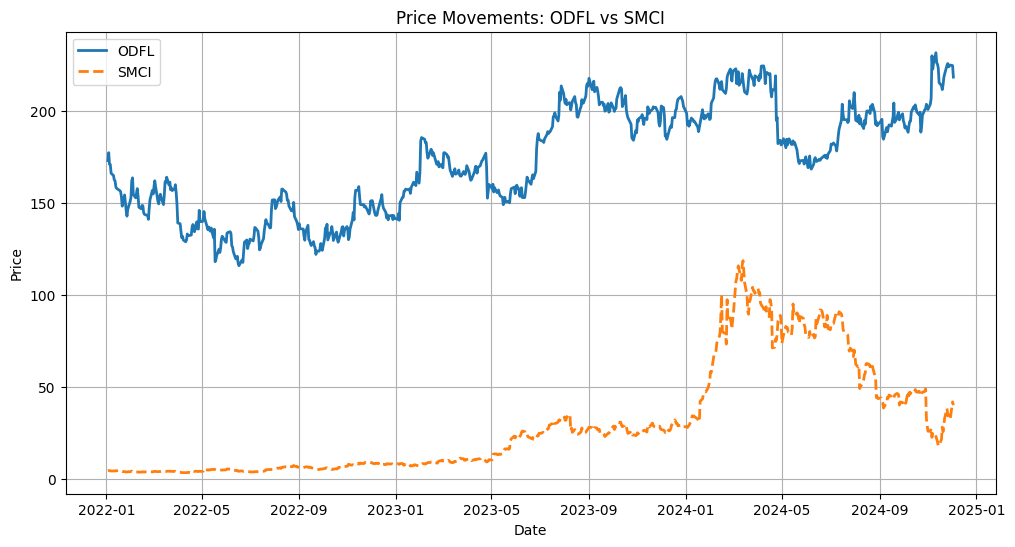

In [144]:
self.plot_pairs('ODFL','SMCI', normalize = False)

In [145]:
df = self.computed_df['AAPL - SMCI']